#  Building a model with K-Train

Build a text classification model that distinguishes articles in the "HEALTHY LIVING/WELLNESS" category from other categories.I would simplify deep learning processes with pre-trained models (e.g. DistilBERT, FastText) for training and evaluation.

## Imports

We're using an API wrapper for Tensorflow called ktrain:

https://github.com/amaiya/ktrain

* python ==3.10
* ktrain ==0.32
* tensorflow ==2.12
* nltk 

In [14]:
# ! pip uninstall ktrain -y
# ! pip install ktrain==0.32

In [15]:
# ! pip uninstall tensorflow -y
# ! pip install tensorflow==2.12
# ! pip install Seaborn
# ! pip install nltk

In [1]:
import os
import ktrain
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

BATCH_SIZE = 32 
SAMPLE_COUNT = 5000

MAXLEN = 512

## Mount Google Drive

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

## Show  GPU information
Ensure GPU availability

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 20 09:23:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960       WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   23C    P8             17W /  180W |     834MiB /   4096MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the data

The data file should be in your Google Drive.

In [2]:
path = "drive/MyDrive/Text_CUB/P1_Final/"
#for local run
path = './'
file = "news_category_trainingdata.json"
news = pd.read_json(path + file)

## Inspect the data

The dataset contains several fields such as category, headline, authors, link, short_description, and date.

In [5]:
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Check the data for missing empty data

In [6]:
news.info()

news.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

To view which categories of data are ranked

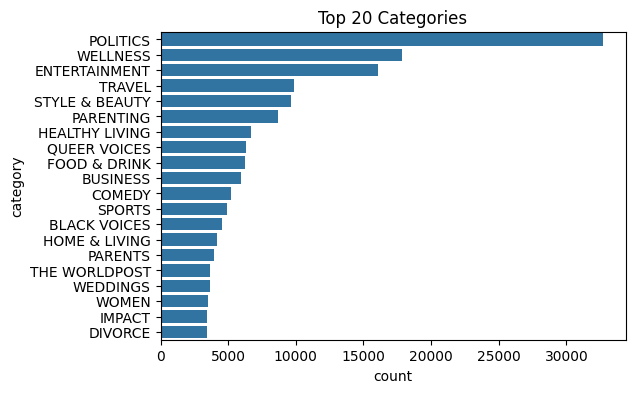

In [7]:
news_cat_count =news["category"].value_counts().head(20)

type(news_cat_count)

f = plt.figure(figsize=(6,4))
sns.barplot(x = 'count',
            y = 'category',
            data =news_cat_count.reset_index().rename(columns = {'index':'category','category':'count'})
            ).set(title='Top 20 Categories')
plt.show()

## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [3]:
news['combined_text'] = news['headline'] + ' ' + news['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a 'is this article about Health & Wellness?' column. That is, when an article belongs to the 'HEALTHY LIVING' or 'WELLNESS' categories, it should be marked with a 1; for any other category, it should be marked with a 0.

In [4]:
well_cat = ['HEALTHY LIVING', 'WELLNESS']
news['H&W'] = np.where((news['category'].isin(well_cat)), 1, 0)
news.head()


,category,headline,authors,link,short_description,date,combined_text,H&W
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


In [10]:
news['H&W'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: H&W, dtype: float64

The data appears to be imbalanced based on the counts provided for the H&W column. Here is a breakdown of the imbalance:

* The count for 0 (articles not about Health & Wellness) is 176,332.
* The count for 1 (articles about Health & Wellness) is 24,521.

Potential Impact:
* Model Bias: An imbalanced dataset can lead to a model that is biased towards predicting the majority class (in this case, 0).
* Performance Metrics: Standard metrics like accuracy might not be reliable. Precision, recall, and F1-score should be considered instead.
* Training Efficiency: The model might learn more from the majority class, potentially overlooking patterns in the minority class.

In [11]:
news['H&W'].value_counts()

0    176332
1     24521
Name: H&W, dtype: int64

## Balance the data



In order to ensure the effectiveness of model training, it is necessary to balance the ratio of positive and negative samples in the data set. Although a full balanced data set is recommended for practical applications, a smaller subset of the data is used for experimental efficiency.

To create a balanced data set that includes all of the health living articles, set sample_amount to the total number of those articles.

In [5]:
wellness = news[news['H&W'] == 1].sample(n=SAMPLE_COUNT)
not_wellness = news[news['H&W'] == 0].sample(n=SAMPLE_COUNT)

Merge the datasets of wellness and non-wellness news articles into a single DataFrame

In [6]:
news_sample = pd.concat([wellness,not_wellness])

In [7]:
news_sample.describe()

,H&W
count,10000.000000
mean,0.500000
std,0.500025
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Remove the specified columns from the DataFrame

In [8]:
news_sample.drop(['category', 'headline', 'authors', 'link', 'short_description', 'date'], axis=1, inplace=True)


## Clean the data

We preprocessing is done to standardize and clean the textual data by removing irrelevant information such as URLs, HTML tags, punctuation, and stop words, ensuring that the remaining content is uniform and focused on meaningful words for analysis. Additionally, it helps in reducing the complexity of the text data by converting all text to lowercase, lemmatizing words to their base forms, and eliminating short words, which improves the performance and accuracy of subsequent text analysis or machine learning models.

In [9]:
news_sample.head()

,combined_text,H&W
103813,6 Diets With Serious Flaws,1
173608,I Lost Weight: After Being Diagnosed With Type...,1
89316,My Choice To Live: Part II,1
138859,Kids Know Better Here's why small children don...,1
166157,Reflections on the Culture of Appearance At th...,1


In [10]:
import re
import string
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# Converts text to lower case
def convert_to_lowercase(text):
    if pd.isna(text):
        return text
    if isinstance(text, str):
        return text.lower()
    return text

# Remove all punctuation from the text
def remove_punctuation(text):
    if pd.isna(text):
        return text
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

# Removes all numbers from the text
def remove_numbers(text):
    if pd.isna(text):
        return text
    text = re.sub(r'\d+', '', text)
    return text

# Text segmentation, then remove the length of 2 or less and the single word and stop word
def remove_short_words_and_stop_words(text):
    if pd.isna(text):
        return text
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

# Replace two or more consecutive Spaces with a single space
def remove_multiple_spaces(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

# Remove urls
def remove_urls(text):
    if pd.isna(text):
        return text
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# Remove htmls
def remove_html(text):
    if pd.isna(text):
        return text
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# Remove @ and #
def remove_tags(text):
    if pd.isna(text):
        return text
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)


def preprocess_text(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '',text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append((each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in stop_words and each_word.strip() != ''
    ]
    return " ".join(word_list)



def clean_text(df, col):
    df[col] = df[col].apply(convert_to_lowercase)
    df[col] = df[col].apply(remove_urls)
    df[col] = df[col].apply(remove_html)
    df[col] = df[col].apply(remove_tags)
    df[col] = df[col].apply(remove_numbers)
    df[col] = df[col].apply(remove_short_words_and_stop_words)
    df[col] = df[col].apply(remove_multiple_spaces) 
    df[col] = df[col].apply(preprocess_text)
    return df

: 

: 

In [ ]:
news_sample = clean_text(news_sample, 'combined_text')

In [ ]:
news_sample.head()

,combined_text,H&W
181594,driving life ego self crucial part learn help ...,1
140423,baking cooking blueberry affect polyphenol lev...,1
133372,cancer daily grind want live annoyed setback f...,1
183666,staying active work improve health video many ...,1
102708,slow medicine see body plant machine,1


We count the number of cleaned words in order to set the appropriate MAXLEN

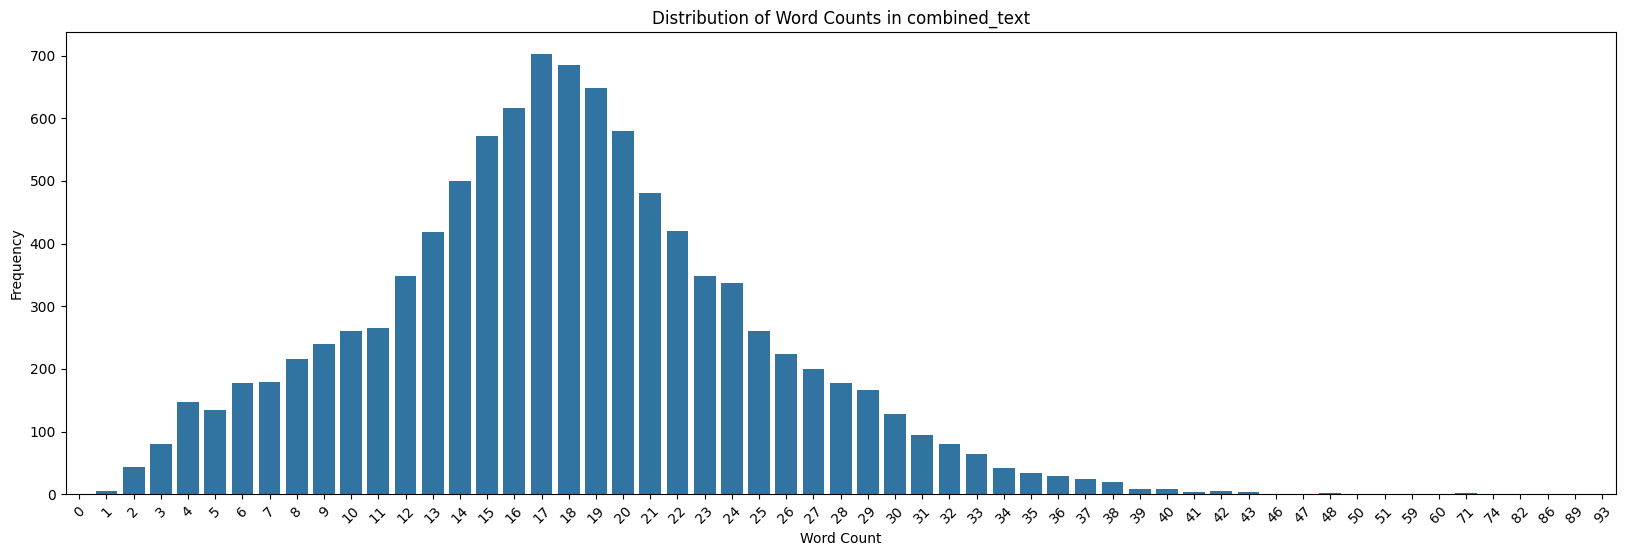

In [20]:

def count_words(text):
    return len(text.split())

news_sample['word_count'] = news_sample['combined_text'].apply(count_words)

word_count_stats = news_sample['word_count'].value_counts().reset_index()
word_count_stats.columns = ['word_count', 'frequency']

plt.figure(figsize=(20, 6))
sns.barplot(x='word_count', y='frequency', data=word_count_stats)
plt.title('Distribution of Word Counts in combined_text')
plt.xlabel('Word Count')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [21]:
MAXLEN = 128

# Model selection and training

Different text classifier models were selected for experiments, 
including **distilbert**, **fasttext**, and **nbsvm**. 

- **DistilBERT** : Lightweight BERT variant for fast training.
- **FastText** : Fast classifier based on bag of words model.
- **NBSVM** : Traditional linear model, dependent on word frequency characteristics.

For each model, the following steps need to be performed:

- Use the 'texts_from_df' method to extract training and validation data from the DataFrame.
- Define and compile the model.
- Find the best parameters using an automatically adjusted learning rate and apply an early stop strategy to avoid overfitting.

See all the models here: https://huggingface.co/transformers/pretrained_models.html


In [37]:
# https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb


ktrain.text.print_text_classifiers()


fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [38]:
target_names = ['not wellness','wellness']

## Model A: distilbert

In [39]:
# release GPU memory for next training
ktrain.release_gpu_memory()
train1, val1, preprocess1 = ktrain.text.texts_from_df(
    news_sample,
    "combined_text",
    label_columns=["H&W"],
    val_df=None,
    max_features=20000,
    maxlen=MAXLEN,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode= "distilbert",
    verbose=1
)

['not_H&W', 'H&W']
        not_H&W  H&W
153570      0.0  1.0
64669       1.0  0.0
64675       1.0  0.0
182905      0.0  1.0
81547       1.0  0.0
['not_H&W', 'H&W']
        not_H&W  H&W
188546      0.0  1.0
148991      1.0  0.0
178669      1.0  0.0
114093      0.0  1.0
188654      0.0  1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 31
	99percentile : 37


In [40]:
modelA = ktrain.text.text_classifier('distilbert', train1, preproc=preprocess1)
learnerA = ktrain.get_learner(modelA, train_data=train1, val_data=val1, batch_size=BATCH_SIZE)

Is Multi-Label? False
maxlen is 128
done.


In [41]:
learnerA.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
281/281 [==============================] - 2224s 8s/step - loss: 0.6731 - accuracy: 0.6152
Epoch 2/6
281/281 [==============================] - 2254s 8s/step - loss: 0.3703 - accuracy: 0.8562
Epoch 3/6
281/281 [==============================] - 2178s 8s/step - loss: 0.3847 - accuracy: 0.8097
Epoch 4/6
281/281 [==============================] - 2133s 8s/step - loss: 0.7027 - accuracy: 0.5013
Epoch 5/6
281/281 [==============================] - 867s 3s/step - loss: 14.5970 - accuracy: 0.5148


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 8.17E-06
	Min numerical gradient (purple): 3.31E-05
	Min loss divided by 10 (omitted from plot): 2.91E-05


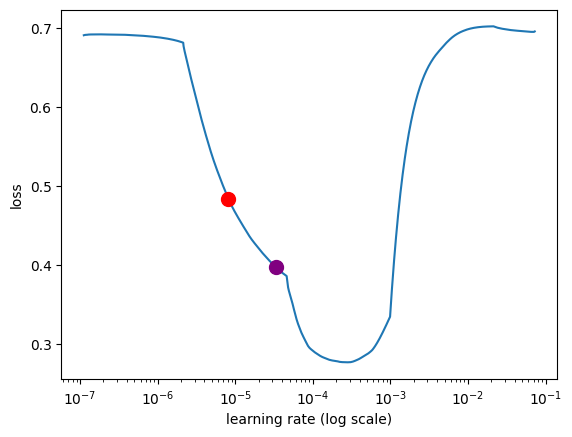

In [42]:
learnerA.lr_plot(suggest = True)

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [44]:
history=learnerA.autofit(
    8.17E-06,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 8.17e-06...
Epoch 1/10
282/282 [==============================] - 2289s 8s/step - loss: 0.6244 - accuracy: 0.6334 - val_loss: 0.4455 - val_accuracy: 0.8330
Epoch 2/10
282/282 [==============================] - 2356s 8s/step - loss: 0.3789 - accuracy: 0.8618 - val_loss: 0.4065 - val_accuracy: 0.8410
Epoch 3/10
282/282 [==============================] - 2485s 9s/step - loss: 0.3287 - accuracy: 0.8756 - val_loss: 0.3813 - val_accuracy: 0.8450
Epoch 4/10
282/282 [==============================] - 2330s 8s/step - loss: 0.3077 - accuracy: 0.8824 - val_loss: 0.3703 - val_accuracy: 0.8480
Epoch 5/10
282/282 [==============================] - 2135s 8s/step - loss: 0.2919 - accuracy: 0.8893 - val_loss: 0.3588 - val_accuracy: 0.8410
Epoch 6/10
282/282 [==============================] - 2172s 8s/step - loss: 0.2764 - accuracy: 0.8937 - val_loss: 0.3538 - val_accuracy: 0.8500
Epoch 7/10
282/282 [==============================] - 

In [ ]:
learnerA.model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation = learnerA.validate(val_data=val1, print_report=True)

1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



## Model B: fasttext

In [ ]:
# release GPU memory for next training
SAMPLE_COUNT = 20000

ktrain.release_gpu_memory()
train2, val2, preprocess2 = ktrain.text.texts_from_df(
    news_sample,
    "combined_text",
    label_columns=["H&W"],
    val_df=None,
    max_features=20000,
    maxlen=MAXLEN,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode= "standard",
    verbose=1
)

['not_H&W', 'H&W']
        not_H&W  H&W
200500      0.0  1.0
93416       1.0  0.0
15612       1.0  0.0
185936      0.0  1.0
47959       1.0  0.0
['not_H&W', 'H&W']
        not_H&W  H&W
78115       1.0  0.0
114431      1.0  0.0
15689       1.0  0.0
16129       0.0  1.0
188197      0.0  1.0
language: en
Word Counts: 20051
Nrows: 9000
9000 train sequences
train sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36
x_train shape: (9000,512)
y_train shape: (9000, 2)
Is Multi-Label? False
1000 test sequences
test sequence lengths:
	mean : 17
	95percentile : 28
	99percentile : 33
x_test shape: (1000,512)
y_test shape: (1000, 2)


In [23]:
modelB = ktrain.text.text_classifier('fasttext', train2, preproc=preprocess2)
learnerB = ktrain.get_learner(modelB, train_data=train2, val_data=val2, batch_size=BATCH_SIZE)

Is Multi-Label? False
compiling word ID features...
maxlen is 512
done.


In [24]:
learnerB.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
282/282 [==============================] - 7s 22ms/step - loss: 1.0037 - accuracy: 0.5002
Epoch 2/6
282/282 [==============================] - 7s 24ms/step - loss: 0.9852 - accuracy: 0.4911
Epoch 3/6
282/282 [==============================] - 7s 24ms/step - loss: 0.8972 - accuracy: 0.5296
Epoch 4/6
282/282 [==============================] - 6s 23ms/step - loss: 0.5884 - accuracy: 0.7004
Epoch 5/6
282/282 [==============================] - 7s 23ms/step - loss: 0.6322 - accuracy: 0.6284
Epoch 6/6
282/282 [==============================] - 3s 9ms/step - loss: 141.0912 - accuracy: 0.4899


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 2.95E-04
	Min numerical gradient (purple): 1.52E-02
	Min loss divided by 10 (omitted from plot): 4.57E-03


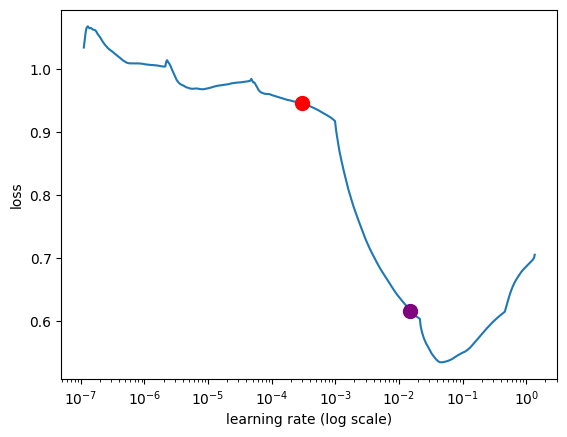

In [25]:

learnerB.lr_plot(suggest = True)

In [26]:
history=learnerB.autofit(
    2.95E-04,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.000295...
Epoch 1/10
282/282 [==============================] - 8s 24ms/step - loss: 0.9182 - accuracy: 0.5156 - val_loss: 0.6867 - val_accuracy: 0.6300
Epoch 2/10
282/282 [==============================] - 7s 25ms/step - loss: 0.7902 - accuracy: 0.5636 - val_loss: 0.6311 - val_accuracy: 0.7810
Epoch 3/10
282/282 [==============================] - 7s 24ms/step - loss: 0.7001 - accuracy: 0.6118 - val_loss: 0.5471 - val_accuracy: 0.8120
Epoch 4/10
282/282 [==============================] - 7s 23ms/step - loss: 0.6279 - accuracy: 0.6618 - val_loss: 0.4977 - val_accuracy: 0.8260
Epoch 5/10
282/282 [==============================] - 7s 24ms/step - loss: 0.5733 - accuracy: 0.7058 - val_loss: 0.4566 - val_accuracy: 0.8400
Epoch 6/10
282/282 [==============================] - 7s 25ms/step - loss: 0.5074 - accuracy: 0.7493 - val_loss: 0.4229 - val_accuracy: 0.8470
Epoch 7/10
282/282 [==============================] - 7s 25m

In [59]:
learnerB.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 64)          0         
 ropout1D)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [60]:
validation = learnerB.validate(val_data=val2, print_report=True)

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       509
           1       0.88      0.84      0.86       491

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



## Model C: nbsvm



In [ ]:
modelC = ktrain.text.text_classifier('fasttext', train2, preproc=preprocess2)
learnerC = ktrain.get_learner(modelC, train_data=train2, val_data=val2, batch_size=BATCH_SIZE)

Is Multi-Label? False
compiling word ID features...
maxlen is 128
done.


In [ ]:
learnerC.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
6/6 [==============================] - 1s 18ms/step - loss: 0.8948 - accuracy: 0.4778
Epoch 2/6
6/6 [==============================] - 0s 21ms/step - loss: 0.9760 - accuracy: 0.4889
Epoch 3/6
6/6 [==============================] - 0s 21ms/step - loss: 0.9873 - accuracy: 0.5167
Epoch 4/6
6/6 [==============================] - 0s 24ms/step - loss: 0.8259 - accuracy: 0.5833
Epoch 5/6
6/6 [==============================] - 0s 21ms/step - loss: 0.6274 - accuracy: 0.6722
Epoch 6/6
6/6 [==============================] - 0s 14ms/step - loss: 47.7719 - accuracy: 0.6328


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


c:\Users\SEELE\.conda\envs\text310\lib\site-packages\ktrain\lroptimize\lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))


Failed to compute the gradients, there might not be enough points.
Plot displayed without suggestion.


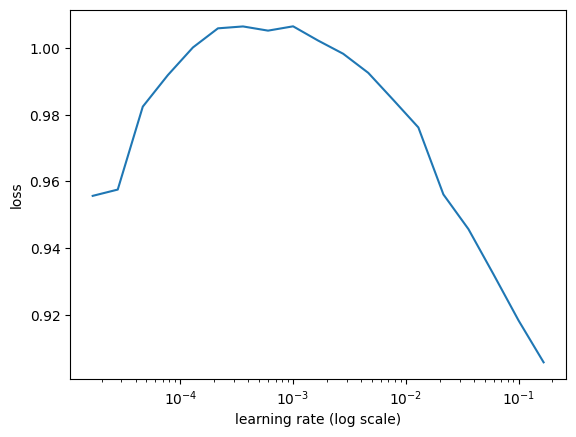

In [ ]:
learnerC.lr_plot(suggest = True)

In [ ]:
history=learnerC.autofit(
    2.57E-04,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.000257...
Epoch 1/10
6/6 [==============================] - 1s 168ms/step - loss: 0.9408 - accuracy: 0.5111 - val_loss: 0.6953 - val_accuracy: 0.4500
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.8295 - accuracy: 0.5389 - val_loss: 0.6949 - val_accuracy: 0.4500
Epoch 3/10
6/6 [==============================] - 0s 32ms/step - loss: 0.8514 - accuracy: 0.5500 - val_loss: 0.6946 - val_accuracy: 0.4500
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.9257 - accuracy: 0.5444 - val_loss: 0.6943 - val_accuracy: 0.4500
Epoch 5/10
6/6 [==============================] - 0s 30ms/step - loss: 0.8097 - accuracy: 0.5500 - val_loss: 0.6940 - val_accuracy: 0.4500
Epoch 6/10
6/6 [==============================] - 0s 31ms/step - loss: 0.8650 - accuracy: 0.5667 - val_loss: 0.6937 - val_accuracy: 0.4500
Epoch 7/10
6/6 [==============================] - 0s 30ms/step - loss: 0.7795 - acc

In [ ]:
learnerC.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 64)           1280000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 128, 64)          0         
 lDropout1D)                                                     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
validation = learnerC.validate(val_data=val2, print_report=True)

1/1 [==============================] - 0s 86ms/step
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.44      1.00      0.62         8

    accuracy                           0.50        20
   macro avg       0.72      0.58      0.45        20
weighted avg       0.78      0.50      0.42        20



# Model evaluation

# Predictor

Get the predictor

In [45]:
predictor = ktrain.get_predictor(learnerA.model, preproc=preprocess1)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [50]:
predictor.save("./Model")

Let's go ahead and make a little set of test documents to check out

In [47]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [48]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

1/1 [==============================] - 2s 2s/step
---------------------------
The probability this is healthy is 0.9787411
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
1/1 [==============================] - 0s 130ms/step
---------------------------
The probability this is healthy is 0.9778286
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
1/1 [==============================] - 0s 129ms/step
---------------------------
The probability this is healthy is 0.4927756
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
1/1 [==============================] - 0s 122ms/step
---------------------------
The probability this is healthy is 0.59254986
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this

*These* are pretty obvious examples, but it works exactly as expected!

In [49]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

c:\Users\SEELE\.conda\envs\text310\lib\site-packages\ktrain\text\predictor.py:137: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."